# Emma and Michael's Dank Boio Modeling and Simulation in Python (Copyright Allen B. Downey) Project Number 3 in the Eleventh Month of the Two Thousand and Eighteenth Year

In [492]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *
import math

In [493]:
x_0 = 362600000 # 362,600 km at perigee
v_0 = 1078.2 # 1078.2 m/s at perigee
Me_0 = 5.9722e24 # 5.9722×10^24 kg
Mm_0 = 7.342e22 # 7.342×10^22 kg

init = State(Me = Me_0, # Initial mass of earth
             Mm = Mm_0, #Initial mass of moon
             x_m=x_0, # 362,600 km at perigee
             y_m=0,
             vx_m=0,
             vy_m=v_0, # 1078.2 m/s at perigee
             x_e = 0,
             y_e = 0,
             vx_e = 0,
             vy_e = 0
            )


,values
Me,5.972200e+24
Mm,7.342000e+22
x_m,3.626000e+08
y_m,0.000000e+00
vx_m,0.000000e+00
vy_m,1.078200e+03
x_e,0.000000e+00
y_e,0.000000e+00
vx_e,0.000000e+00
vy_e,0.000000e+00


In [494]:
num_rockets = 1e8

def earth_radius(mass):
    density = 5514 # 5514 kg/m3 from NASA Earth Fact Sheet
    Re = (3*mass / (4*pi*density))**(1/3)
    return Re

def moon_radius(mass):
    density = 3344 # 3344 kg/m3 from NASA Moon Fact Sheet
    Rm = (3*mass / (4*pi*density))**(1/3)
    return Rm

system = System(init=init,
                dmdt = 6.54e6*num_rockets, #kg/s,
                r_e = earth_radius,
                r_m = moon_radius,
                G=6.674e-11, #N / kg**2 * m**2
                t_0=0,
                t_end=10*365*24*60*60) 

,values
init,Me 5.972200e+24 Mm 7.342000e+22 x_m ...
dmdt,6.54e+14
r_e,<function earth_radius at 0x000001F979709048>
r_m,<function moon_radius at 0x000001F97ACBE0D0>
G,6.674e-11
t_0,0
t_end,315360000


In [495]:
def net_force_moon(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    
    #Gravitational Force
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    force= G * Me * Mm / r**2
    direction = math.atan2(y_m-y_e,x_m-x_e) + pi 
    gravitational_force = Vector(force * math.cos(direction), force*math.sin(direction) )
    
    # Moon momentum contribution
    collision_force = dmdt * -(Vector(vx_m,vy_m))
    
    return gravitational_force + collision_force

In [496]:
def net_force_earth(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    
    #Gravitational Force
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    force= G * Me * Mm / r**2
    direction = math.atan2(y_m-y_e,x_m-x_e)
    gravitational_force = Vector(force * math.cos(direction), force*math.sin(direction) )
    
    return gravitational_force

In [497]:
print(net_force_moon(init, system))
print(net_force_earth(init, system))

[-2.22576509e+20 -7.05142800e+17] dimensionless
[2.22576509e+20 0.00000000e+00] dimensionless


In [498]:
def slope_func(state,t,system):
    
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    V_m = Vector(vx_m,vy_m)
    V_e = Vector(vx_e,vy_e)
    
    Fnet_m = net_force_moon(state,system)
    Fnet_e = net_force_earth(state,system)
    
    dMedt = -dmdt
    dMmdt = dmdt
    dxdt_m = V_m
    dvdt_m = Fnet_m / Mm
    dxdt_e = V_e
    dvdt_e = Fnet_e / Me
    
    return dMedt, dMmdt, dxdt_m[0], dxdt_m[1], dvdt_m[0], dvdt_m[1], dxdt_e[0], dxdt_e[1], dvdt_e[0], dvdt_e[1],

In [499]:
slope_func(init, 0, system)

(-654000000000000.0,
 654000000000000.0,
 <Quantity(0.0, 'dimensionless')>,
 <Quantity(1078.2, 'dimensionless')>,
 <Quantity(-0.0030315514688456138, 'dimensionless')>,
 <Quantity(-9.604233178969938e-06, 'dimensionless')>,
 <Quantity(0.0, 'dimensionless')>,
 <Quantity(0.0, 'dimensionless')>,
 <Quantity(3.726876341091138e-05, 'dimensionless')>,
 <Quantity(0.0, 'dimensionless')>)

In [500]:
def event_func(state,t,system):
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
   
    r = sqrt(x_m**2 + y_m**2)
    r_collision = earth_radius(Me) + moon_radius(Mm)
    
    return r - r_collision

def event_func(state,t,system):
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
   
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    collision_radius = earth_radius(Me) + moon_radius(Mm)
    
    #End the simulart if there is a collision OR if the orbital radius exceeds its initial value at apogee
    if(Me < 0):
        print('Negative mass is really sad...')
        return 0
    elif(r > 0.4055e10): # e9 originally
        print('The moon escaped our experiment!')
        return 0
    else:
        return r - collision_radius


In [501]:
event_func(init,0,system)

354492134.3300541

In [502]:
results, details = run_ode_solver(system, slope_func,events=event_func, method="LSODA")
details

,values
sol,None
t_events,[[179479024.35511008]]
nfev,43996
njev,290
nlu,290
status,1
message,A termination event occurred.
success,True


In [503]:
results.index /= 24*60*60

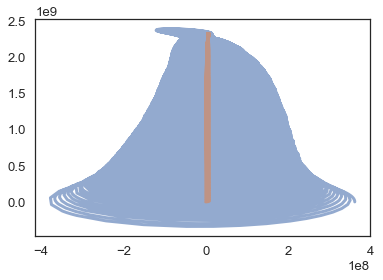

In [504]:
plot(results.x_m,results.y_m)
plot(results.x_e,results.y_e)

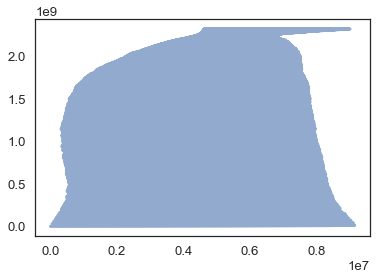

In [505]:
plot(results.x_e,results.y_e)

In [506]:
results.index[-1]

2077.303522628589

In [507]:
results.head()

,Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e
0.000000e+00,5.972200e+24,7.342000e+22,362600000.0,0.000000,0.000000e+00,1078.2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3.394587e-13,5.972200e+24,7.342000e+22,362600000.0,0.000032,-8.891307e-11,1078.2,3.205873e-20,0.000000e+00,1.093064e-12,9.532742e-26
6.789174e-13,5.972200e+24,7.342000e+22,362600000.0,0.000063,-1.778261e-10,1078.2,9.617619e-20,5.591760e-33,2.186128e-12,2.859823e-25
3.395266e-09,5.972200e+24,7.342000e+22,362600000.0,0.316291,-8.893086e-07,1078.2,1.603578e-12,6.992497e-22,1.093283e-08,4.768278e-18
6.789853e-09,5.972200e+24,7.342000e+22,362600000.0,0.632519,-1.778439e-06,1078.2,6.413029e-12,4.194939e-21,2.186347e-08,1.906930e-17


In [508]:
results.tail()

,Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e
2077.295405,5.854821e+24,1.907988e+23,8.544917e+06,2.318776e+09,6106.267208,5710.432611,4.790879e+06,2.328144e+09,-198.991774,-172.839286
2077.297671,5.854821e+24,1.907990e+23,9.708135e+06,2.319963e+09,5750.066621,6422.027965,4.752972e+06,2.328108e+09,-187.383918,-196.029129
2077.299938,5.854821e+24,1.907991e+23,1.078537e+07,2.321290e+09,5224.690136,7130.449884,4.717867e+06,2.328068e+09,-170.262880,-219.115585
2077.302204,5.854821e+24,1.907992e+23,1.174238e+07,2.322750e+09,4520.682020,7775.881896,4.686680e+06,2.328023e+09,-147.320501,-240.149334
2077.303523,5.854821e+24,1.907993e+23,1.223053e+07,2.323655e+09,4036.677047,8095.026953,4.670772e+06,2.327995e+09,-131.547607,-250.549861
